In [4]:
! pip install numpyro corner healpy einops reproject

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# run only if LaTeX is needed
! sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-15).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2019.202000218-1).
texlive-latex-recommended is already the newest version (2019.20200218-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [6]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append(r'/content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/')
%cd /content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Othercomputers/My MacBook Pro/gce-prob-prog/notebooks


In [7]:
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner

import jax
import numpyro.handlers as handlers

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('matplotlibrc')

In [8]:
from models.poissonian_cart import GCEPyModel, GCEPyModelSimple

In [103]:
ebinmodel_gcepy = GCEPyModel()

In [9]:
output_dir = '../output/posteriors'

## 1. fit
### 1.1 single energy

In [104]:
for ie in range(ebinmodel_gcepy.mask.shape[0]):
    svi_results = ebinmodel_gcepy.fit_SVI(
        ebin=ie,
        rng_key=jax.random.PRNGKey(424),
        n_steps=10000,
        guide="iaf",
        lr=5e-5,
        num_flows=5,
        hidden_dims=[128, 128],
        num_particles=16,
    )
    samples = ebinmodel_gcepy.get_svi_samples(num_samples=50000, expand_samples=True)
    pickle.dump((samples, svi_results), open(f'{output_dir}/compare_gcepy/gcepy_svi_ie{ie}_2.p', 'wb'))

  0%|          | 0/10000 [00:04<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
s = pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_ie0.p', 'rb'))[0]

### 1.2 full

In [ ]:
svi_results = ebinmodel_gcepy.fit_SVI(
    rng_key=jax.random.PRNGKey(42),
    num_flows=5, hidden_dims=[128, 128],
    n_steps=20000, lr=3e-5, num_particles=16,
    ebin='all',
    error_mode='ll',
)

100%|██████████| 20000/20000 [05:04<00:00, 65.58it/s, init loss: 1204843520.0000, avg. loss [19001-20000]: 1877533.1250]


In [ ]:
svi_results.losses[-1]

Array(1877546., dtype=float32)

In [ ]:
samples = ebinmodel_gcepy.get_svi_samples(num_samples=50000, expand_samples=True)
pickle.dump((samples, svi_results), open(f'{output_dir}/compare_gcepy/gcepy_svi_full_errll_par16_3.p', 'wb'))

1877752.2, 1877605.5, 1879100., \
1877573.9, 1877546.

## 2. Plotting

In [47]:
ebin_edges = np.array([0.275, 0.357, 0.464, 0.603, 0.784, 1.02, 1.32, 1.72,
                       2.24, 2.91, 3.78, 4.91, 10.8, 23.7, 51.9])
ebin_centers = (ebin_edges[1:] + ebin_edges[:-1]) / 2

### 2.1 single energy

<ipython-input-105-789b638bf590>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  f'ie{ie}' : mpl.cm.get_cmap('rainbow')(ie/(ie_tot-1))


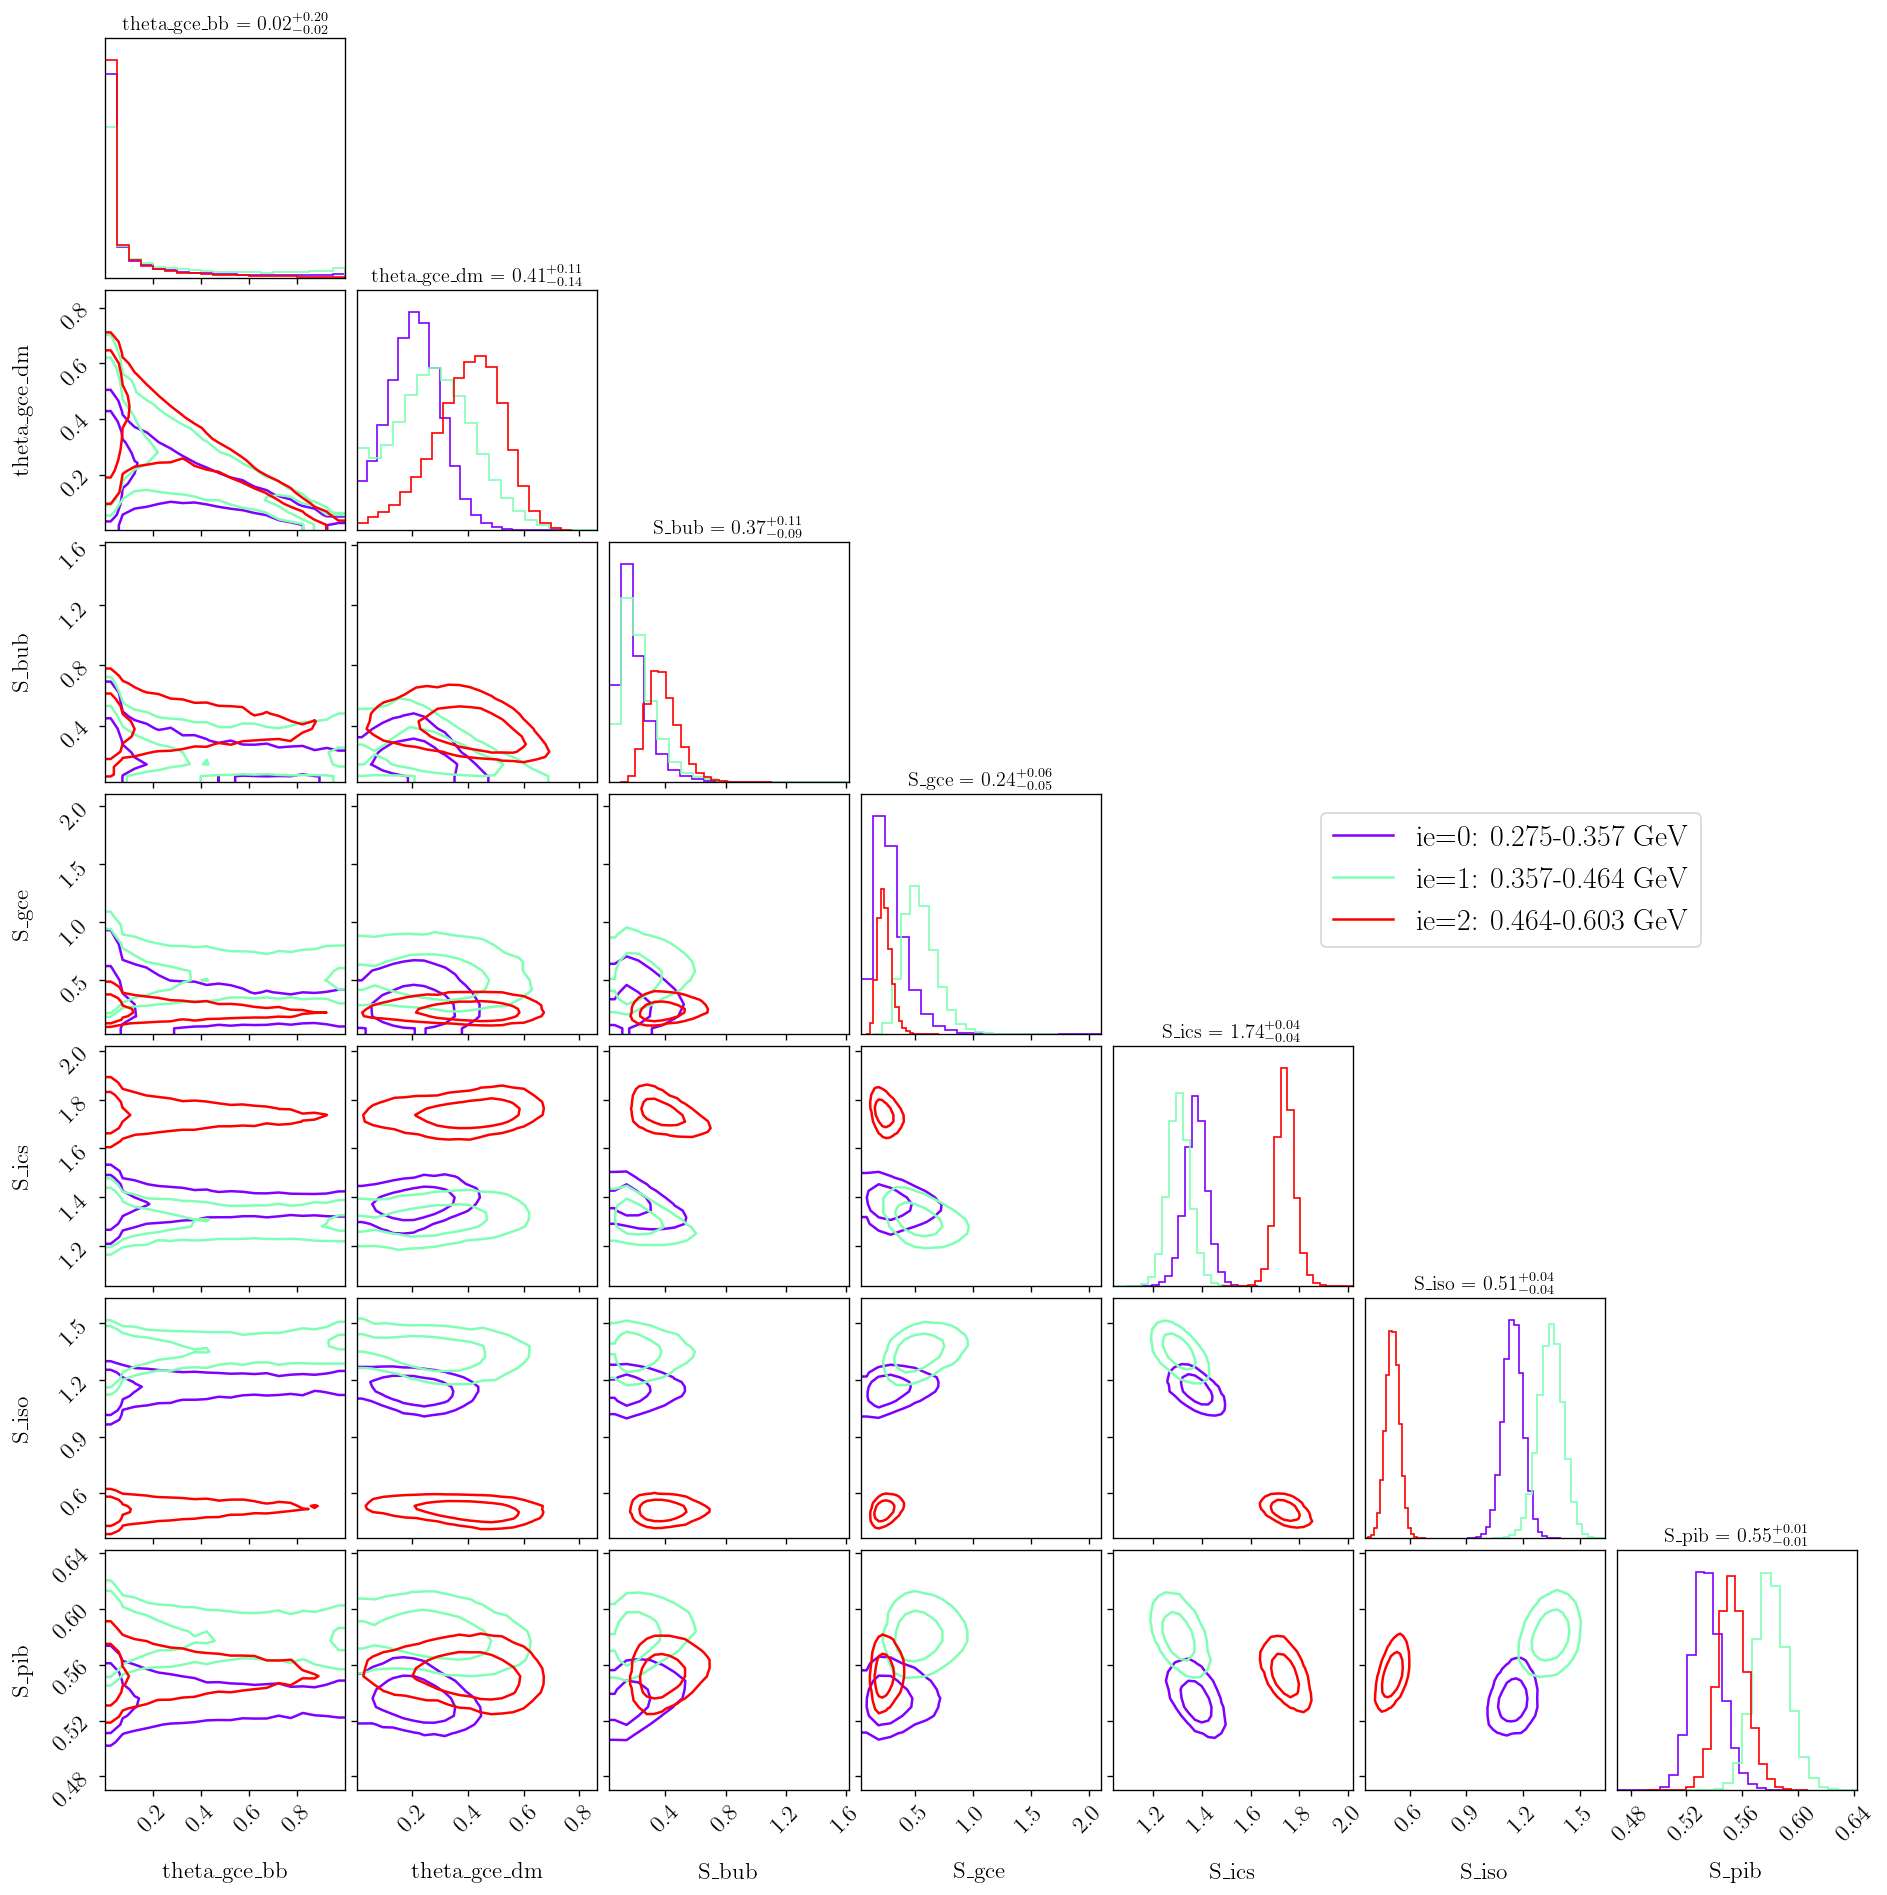

In [105]:
samples_dict = {}
ie_tot = 3
for ie in range(ie_tot):
    s = pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_ie{ie}_2.p', 'rb'))[0]
    s['theta_gce_bulges'] = s['theta_gce_bbp'] + s['theta_gce_bb'] + s['theta_gce_x']
    samples_dict[f'ie{ie}'] = s

colors_dict = {
    f'ie{ie}' : mpl.cm.get_cmap('rainbow')(ie/(ie_tot-1))
    for ie in range(ie_tot)
}

plot_var_names = [
    'theta_gce_bb', 'theta_gce_dm',
    #'log10S_bub', 'log10S_gce', 'log10S_ics', 'log10S_iso', 'log10S_pib',
    'S_bub', 'S_gce', 'S_ics', 'S_iso', 'S_pib',
]

n_bins_1d = 30
bins_1d_arr = []
for vn in plot_var_names:
    vmin = np.min([np.min(s[vn]) for _, s in samples_dict.items()])
    vmax = np.max([np.max(s[vn]) for _, s in samples_dict.items()])
    bins_1d_arr.append(np.linspace(vmin, vmax, n_bins_1d + 1))

figure = None
for ie, (samples_name, samples) in enumerate(samples_dict.items()):
    color = mpl.colors.to_hex(colors_dict[samples_name])
    figure = corner.corner(
        samples,
        bins_1d_arr=bins_1d_arr,
        var_names=plot_var_names,
        show_titles=True,
        title_kwargs={"fontsize": 12},
        levels = [0.68, 0.95],
        color = color,
        plot_contours=True,
        fill_contours=False,
        plot_density=False,
        plot_datapoints=False,
        fig=figure,
    )
    #figure.text(0.4, 0.8+0.012*ie, , fontsize=16, color=color)

figure.legend(
    [mpl.lines.Line2D([0], [0], color=c) for k, c in colors_dict.items()],
    [f'ie={ie}: {ebin_edges[ie]}-{ebin_edges[ie+1]} GeV' for ie in range(14)],
    loc=(0.7, 0.5)
)

# ndim = len(plot_var_names)
# axs = np.array(figure.axes).reshape((ndim, ndim))

# MAP_estimates, _ = pickle.load(open(f'{output_dir}/check_SVI/ebin10_MAP.p', 'rb'))

# for i, v in enumerate(plot_var_names):
#     axs[i,i].axvline(MAP_estimates[v], color='k')
    
# for ri in range(ndim):
#     for ci in range(ri):
#         axs[ri,ci].plot(MAP_estimates[plot_var_names[ci]], MAP_estimates[plot_var_names[ri]], '*', color='k', ms=10)

#plt.savefig('../output/posteriors/plots/gcepy_noprior.pdf')

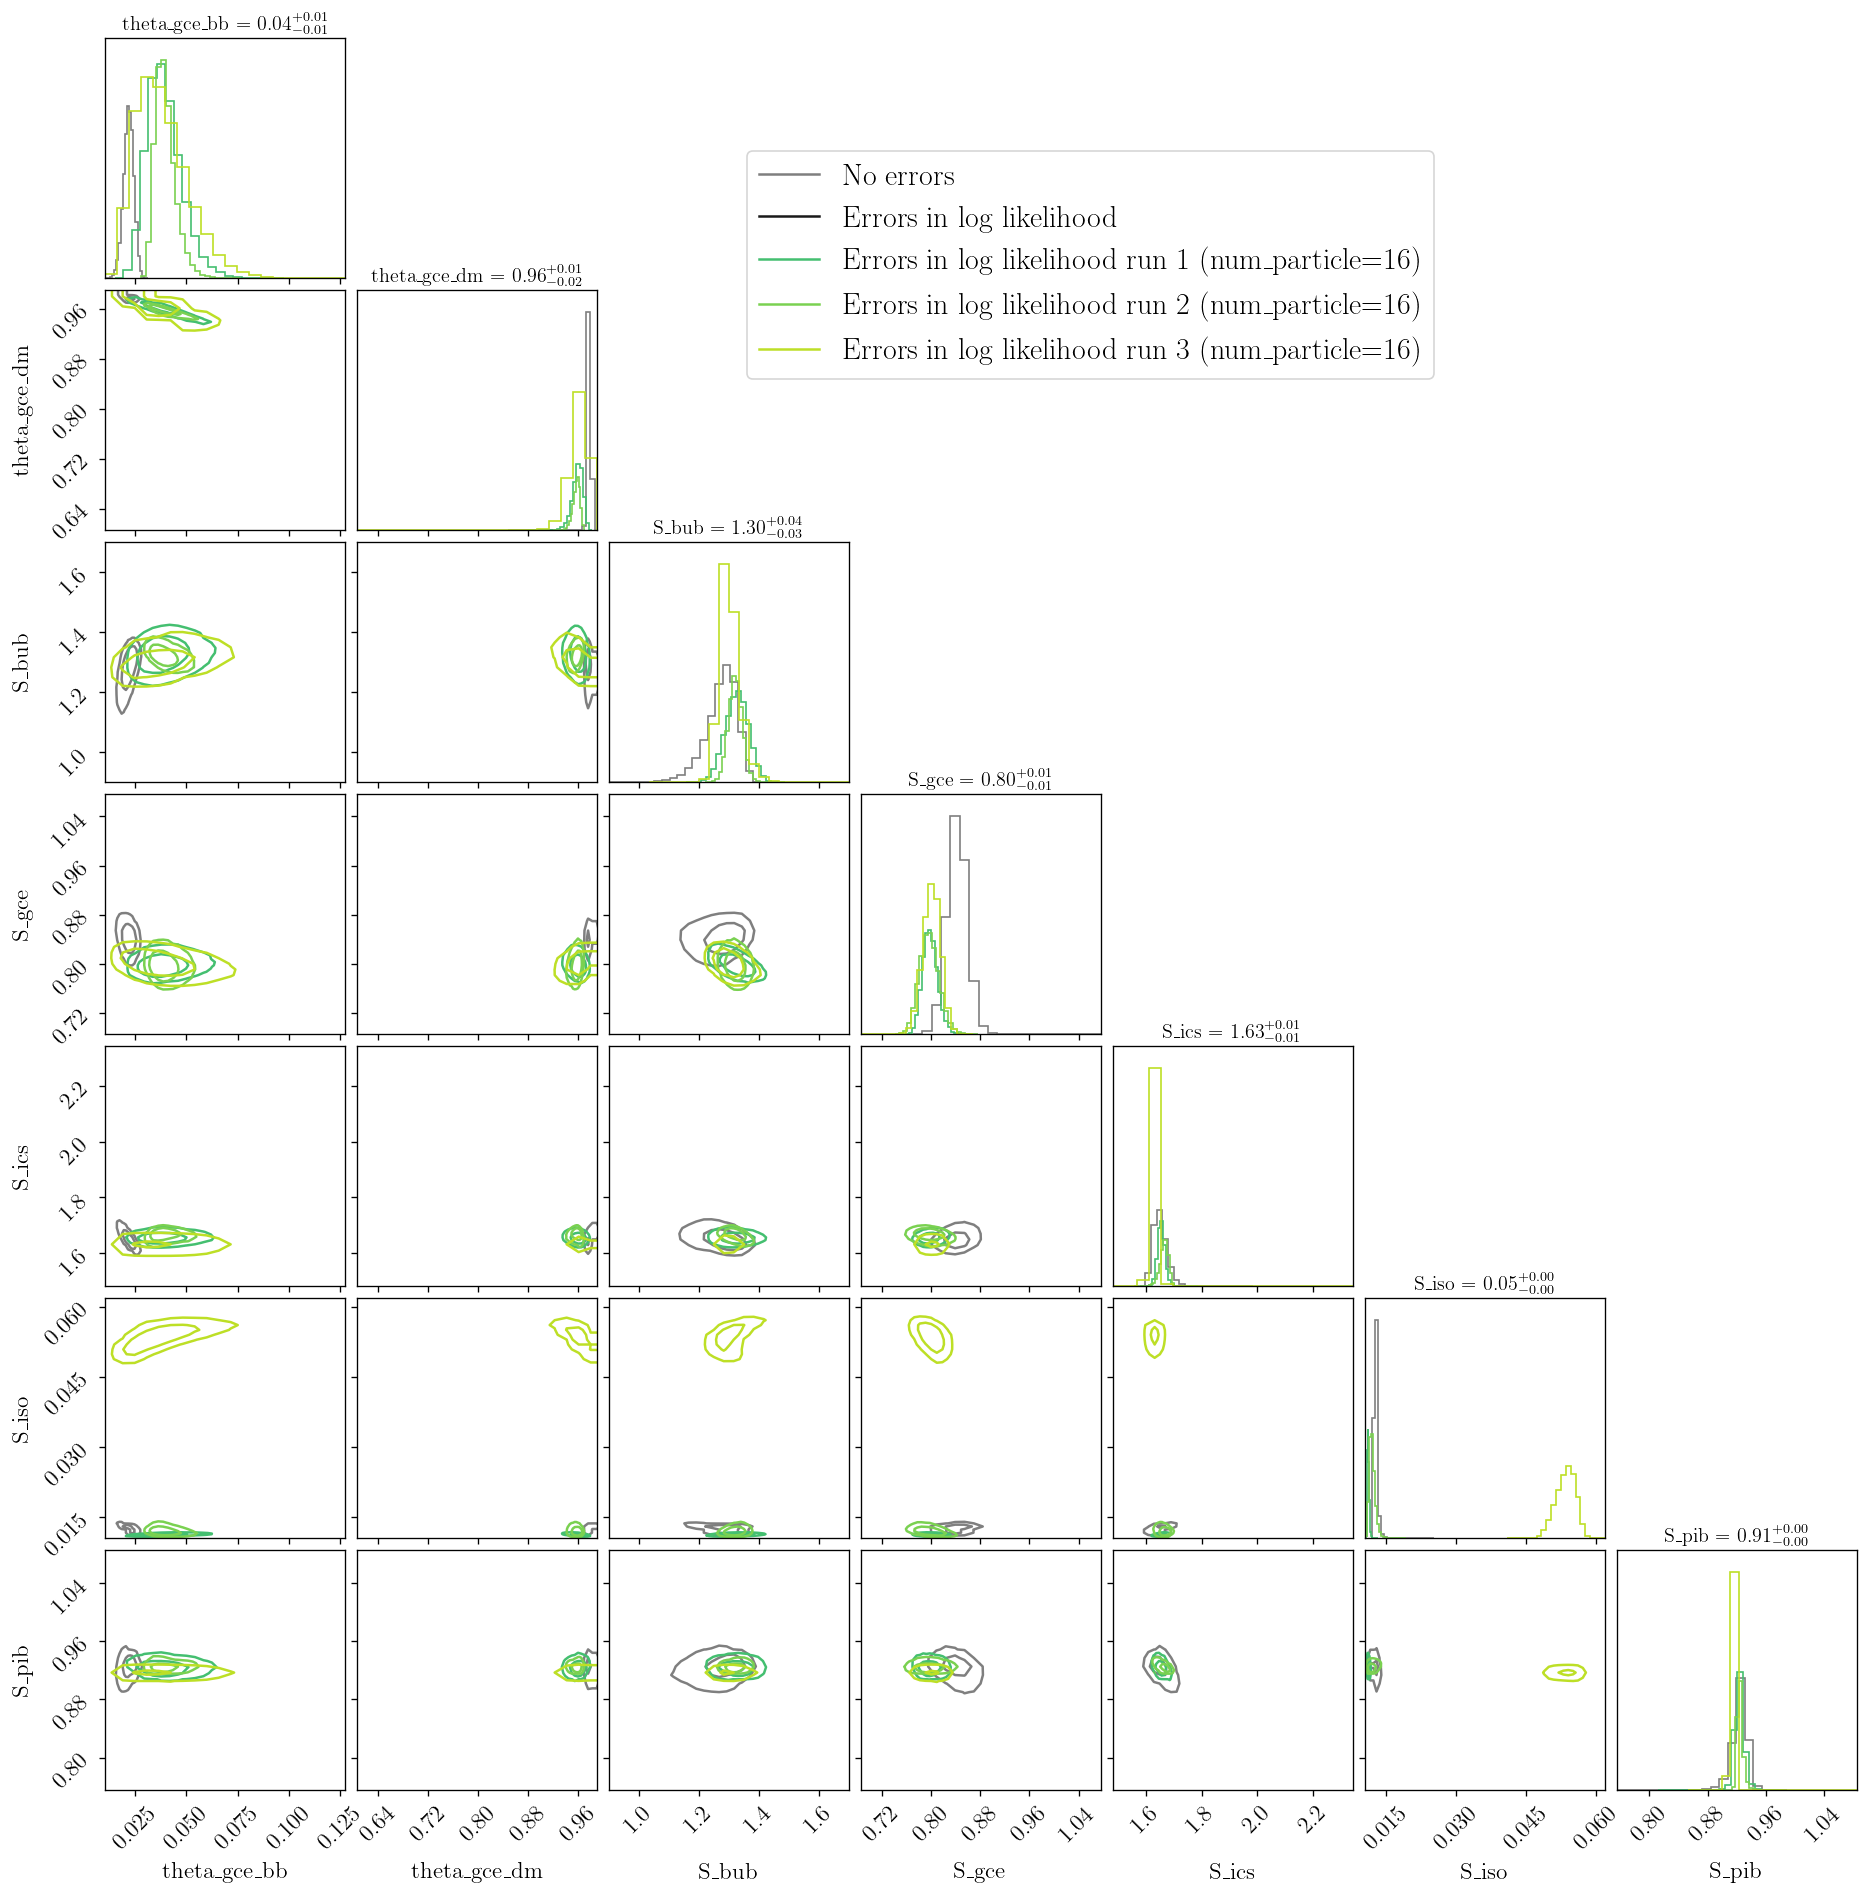

In [ ]:
samples_dict = {
    'noerr' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full.p', 'rb'))[0],
    #'errll' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full_errll.p', 'rb'))[0],
    'errll_1' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full_errll_par16_1.p', 'rb'))[0],
    'errll_2' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full_errll_par16_2.p', 'rb'))[0],
    'errll_3' : pickle.load(open(f'{output_dir}/compare_gcepy/gcepy_svi_full_errll_par16_3.p', 'rb'))[0],
}
colors_dict = {
    'noerr' : mpl.colormaps['binary'](0.5),
    'errll' : mpl.colormaps['binary'](0.9),
    'errll_1' : mpl.colormaps['viridis'](0.7),
    'errll_2' : mpl.colormaps['viridis'](0.8),
    'errll_3' : mpl.colormaps['viridis'](0.9),
}
names_dict = {
    'noerr' : 'No errors',
    'errll' : 'Errors in log likelihood',
    'errll_1' : 'Errors in log likelihood run 1 (num_particle=16)',
    'errll_2' : 'Errors in log likelihood run 2 (num_particle=16)',
    'errll_3' : 'Errors in log likelihood run 3 (num_particle=16)',
}
plot_var_names = [
    'theta_gce_bb', 'theta_gce_dm',
    'S_bub', 'S_gce', 'S_ics', 'S_iso', 'S_pib',
]

n_bins_1d = 30
bins_1d_arr = []
for vn in plot_var_names:
    vmin = np.min([np.min(s[vn]) for _, s in samples_dict.items()])
    vmax = np.max([np.max(s[vn]) for _, s in samples_dict.items()])
    bins_1d_arr.append(np.linspace(vmin, vmax, n_bins_1d + 1))

figure = None
for ie, (samples_name, samples) in enumerate(samples_dict.items()):
    color = mpl.colors.to_hex(colors_dict[samples_name])
    figure = corner.corner(
        samples,
        bins_1d_arr=bins_1d_arr,
        var_names=plot_var_names,
        show_titles=True,
        title_kwargs={"fontsize": 12},
        levels = [0.68, 0.95],
        color = color,
        plot_contours=True,
        fill_contours=False,
        plot_density=False,
        plot_datapoints=False,
        fig=figure,
    )
    #figure.text(0.4, 0.8+0.012*ie, samples_name, fontsize=18, color=color)

figure.legend(
    [mpl.lines.Line2D([0], [0], color=c) for k, c in colors_dict.items()],
    [names_dict[k] for k, c in colors_dict.items()],
    loc=(0.4, 0.8)
)

# ndim = len(plot_var_names)
# axs = np.array(figure.axes).reshape((ndim, ndim))

# MAP_estimates, _ = pickle.load(open(f'{output_dir}/check_SVI/ebin10_MAP.p', 'rb'))

# for i, v in enumerate(plot_var_names):
#     axs[i,i].axvline(MAP_estimates[v], color='k')
    
# for ri in range(ndim):
#     for ci in range(ri):
#         axs[ri,ci].plot(MAP_estimates[plot_var_names[ci]], MAP_estimates[plot_var_names[ri]], '*', color='k', ms=10)

plt.savefig('../output/posteriors/plots/gcepy_full.pdf')

## 3. Low dimensional model

In [96]:
from models.poissonian_cart import GCEPyModelSimple

In [97]:
m = GCEPyModelSimple()

fixed2


In [101]:
samples_dict = {}
for ie in range(6, 7):
    svi_results = m.fit_SVI(
        rng_key=jax.random.PRNGKey(42765),
        num_flows=5, hidden_dims=[128, 128],
        n_steps=7500, lr=3e-5, num_particles=16,
        ebin=ie,
        error_mode='ll',
        dif_option='8t',
        log_S=False
    )
    samples_dict[str(ie)] = m.get_svi_samples(num_samples=50000, expand_samples=True)
#pickle.dump(svi_results, open(f"{output_dir}/", 'wb'))

100%|██████████| 7500/7500 [00:14<00:00, 522.26it/s, init loss: 126611088.0000, avg. loss [7126-7500]: -1348775.6250]


In [ ]:
samples_dict['6'].pop()

[]

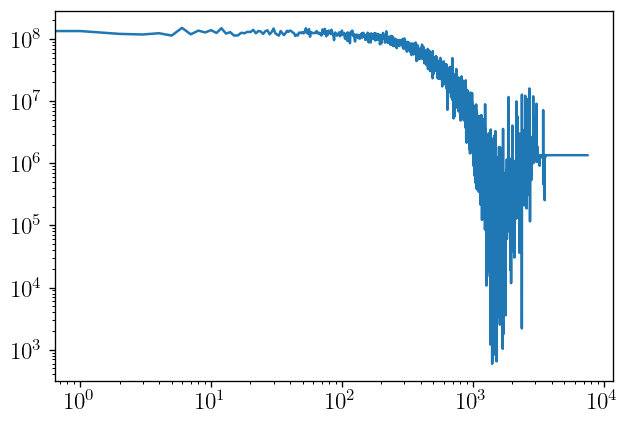

In [99]:
plt.plot(np.abs(svi_results.losses))
plt.loglog()

In [80]:
m.run_parallel_tempering_hmc(num_samples=20000, use_neutra=False)
samples_hmc = m.pt_mcmc.get_samples()

  0%|          | 0/20600 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
sample: 100%|██████████| 20600/20600 [00:34<00:00, 594.63it/s]


In [85]:
m.run_parallel_tempering_hmc(num_samples=20000, use_neutra=True)
samples_hmc_nt = m.pt_mcmc.get_samples()
samples_hmc_nt.pop('auto_shared_latent')

  0%|          | 0/20600 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
sample: 100%|██████████| 20600/20600 [01:03<00:00, 322.63it/s]


Array([[  0.6179345 ,  -0.65779465,   0.94216764,  -0.66646695,
          3.6781406 ,   1.0790633 ],
       [  0.9025669 ,  -0.8853259 ,   1.1095827 ,  -0.7425875 ,
          3.4807658 ,   1.1349068 ],
       [  1.2217462 ,  -0.8816765 ,   0.87896746,  -0.91379297,
          3.381728  ,   1.0195932 ],
       ...,
       [  1.6551855 ,   1.676292  ,  -0.40503377, -19.555725  ,
         -7.5619535 ,   0.6784461 ],
       [  1.6551855 ,   1.676292  ,  -0.40503377, -19.555725  ,
         -7.5619535 ,   0.6784461 ],
       [  1.6551855 ,   1.676292  ,  -0.40503377, -19.555725  ,
         -7.5619535 ,   0.6784461 ]], dtype=float32)

In [ ]:
np.mean(svi_results.losses[-1000:])

In [86]:
print('Estart - Eend f_blg_mean f_blg_std')
for ie in range(6,7):
    print(
        ebin_edges[ie], '-', ebin_edges[ie+1],
        np.mean(samples_dict[str(ie)]['f_blg']),
        np.std(samples_dict[str(ie)]['f_blg']),
    )

Estart - Eend f_blg_mean f_blg_std
1.32 - 1.72 0.5431632 0.24980663


In [53]:
colors_dict = {str(ie) : mpl.colormaps['rainbow'](ie/13) for ie in range(14)}
names_dict = {str(ie) : str(ie) for ie in range(14)}

In [81]:
samples_dict['hmcnt'] = samples_hmc_nt
colors_dict['hmcnt'] = 'r'
names_dict['hmcnt'] = 'hmcnt'
samples_dict['hmc'] = samples_hmc
colors_dict['hmc'] = 'b'
names_dict['hmc'] = 'hmc'

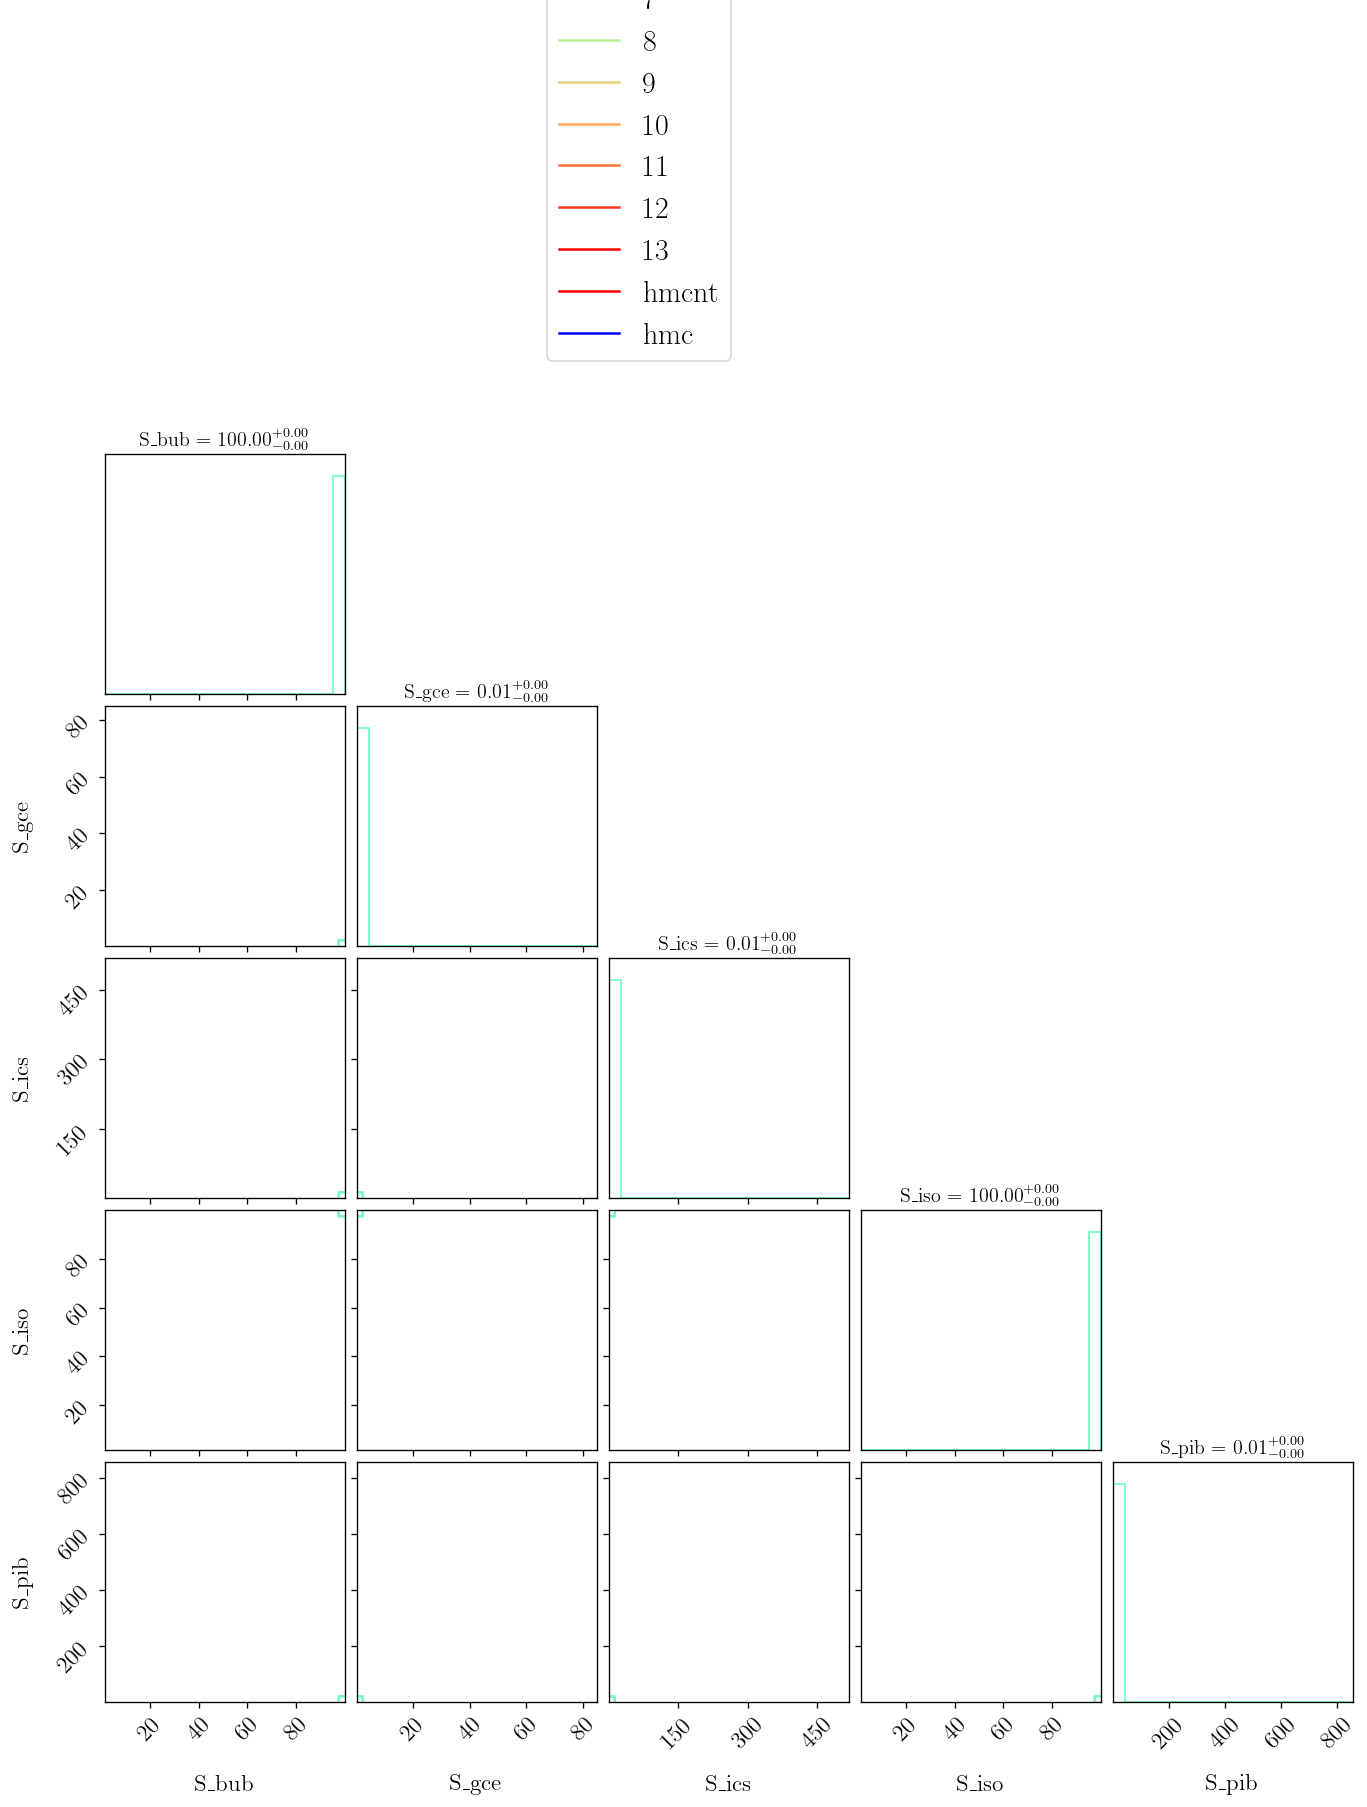

In [102]:
# samples_dict = {
#     '7p' : samples_svi,
#     #'7phmc' : samples_hmc,
#     '7phmcnt' : samples_hmc_nt,
# }
# colors_dict = {
#     '7p' : mpl.colormaps['plasma'](0.2),
#     '7phmc' : mpl.colormaps['plasma'](0.5),
#     '7phmcnt' : mpl.colormaps['plasma'](0.8),
# }
# names_dict = {
#     '7p' : '7p SVI',
#     '7phmc' : '7p HMC',
#     '7phmcnt' : '7p HMC NeuTra',
# }
plot_var_names = [
    #'f_blg',
    #'log10S_bub', 'log10S_gce', 'log10S_ics', 'log10S_iso', 'log10S_pib',
    'S_bub', 'S_gce', 'S_ics', 'S_iso', 'S_pib',
]

n_bins_1d = 30
bins_1d_arr = []
range_arr = []
for vn in plot_var_names:
    vmin = np.min([np.min(s[vn]) for _, s in samples_dict.items()])
    vmax = np.max([np.max(s[vn]) for _, s in samples_dict.items()])
    bins_1d_arr.append(np.linspace(vmin, vmax, n_bins_1d + 1))
    range_arr.append([vmin, vmax])

figure = None
for ie, (samples_name, samples) in enumerate(samples_dict.items()):
    color = mpl.colors.to_hex(colors_dict[samples_name])
    figure = corner.corner(
        samples,
        bins_1d_arr=bins_1d_arr,
        range=range_arr,
        var_names=plot_var_names,
        show_titles=True,
        title_kwargs={"fontsize": 12},
        levels = [0.68, 0.95],
        color = color,
        plot_contours=True,
        fill_contours=False,
        plot_density=False,
        plot_datapoints=False,
        fig=figure,
    )
    #figure.text(0.4, 0.8+0.012*ie, samples_name, fontsize=18, color=color)

figure.legend(
    [mpl.lines.Line2D([0], [0], color=c) for k, c in colors_dict.items()],
    [names_dict[k] for k, c in colors_dict.items()],
    loc=(0.4, 0.8)
)

#plt.savefig('../output/posteriors/plots/gcepy_full.pdf')

DM: 1877514.1
BB:
BBP:
X:
C19:

In [ ]:
samples = ebinmodel_gcepy.get_svi_samples(num_samples=50000, expand_samples=True)
pickle.dump((samples, svi_results), open(f'{output_dir}/compare_gcepy/gcepy_svi_full_errll_par16_3.p', 'wb'))

In [ ]:
for gce_option in ['dm', 'bb', 'bbp', 'x', 'c19']


## Debug

In [ ]:
with handlers.seed(rng_seed=42):
    ll = ebinmodel_gcepy.model_full(None)
    print(ll)

None
